<a href="https://colab.research.google.com/github/marcinwolter/NORCC-SUMMER_2022/blob/main/simple_mnist_mdn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple MNIST dense net with Mixture Density Network

Using on:
https://keras.io/examples/vision/mnist_convnet/ 

## Setup

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


## Prepare the data

In [2]:

def prepare_data(x_train, y_train, x_test, y_test,num_classes):
  #Select 2 classes
  N_CLASSES = num_classes

  indices = np.where(y_train < N_CLASSES) # if few classes needed
  indices = indices[0]
  np.random.shuffle(indices)
  x_train = x_train[indices]
  y_train = y_train[indices]

  indices = np.where(y_test < N_CLASSES) # if few  classes only
  indices = indices[0]
  np.random.shuffle(indices)
  x_test = x_test[indices]
  y_test = y_test[indices]

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255
  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)
  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")


  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  
  return x_train, y_train, x_test, y_test

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train, y_train, x_test, y_test = prepare_data(x_train, y_train, x_test, y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# **Install keras-mdn-layer**

In [4]:
! pip install keras-mdn-layer
import mdn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Parameters for MDN

In [5]:
N_HIDDEN = 64  # number of hidden units in the Dense layer
N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = num_classes  # number of real-values predicted by each mixture component


## Build the model

In [6]:
model = keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(layers.Flatten())
model.add(layers.Dense(N_HIDDEN, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(N_HIDDEN, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(N_HIDDEN, activation="relu"))
model.add(layers.Dropout(0.2))
# Here comes the MDN layer
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

## Train the model

In [12]:
batch_size = 128
epochs = 100

# This was for normal dense network
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam())


history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test)) #validation_split=0.1)

Epoch 1/100
469/469 [==============================] - 3s 5ms/step - loss: -11.8537 - val_loss: -20.5013
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: -17.8583 - val_loss: -21.2000
Epoch 3/100
469/469 [==============================] - 2s 4ms/step - loss: -18.2785 - val_loss: -20.2971
Epoch 4/100
469/469 [==============================] - 2s 4ms/step - loss: -17.9567 - val_loss: -20.3507
Epoch 5/100
469/469 [==============================] - 2s 4ms/step - loss: -17.1249 - val_loss: -20.1135
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: -16.1603 - val_loss: -13.7714
Epoch 7/100
469/469 [==============================] - 2s 4ms/step - loss: -16.0987 - val_loss: -19.3718
Epoch 8/100
469/469 [==============================] - 2s 5ms/step - loss: -17.0548 - val_loss: -19.0493
Epoch 9/100
469/469 [==============================] - 2s 4ms/step - loss: -17.1189 - val_loss: -18.4185
Epoch 10/100
469/469 [==============================] -

# **Plot loss**

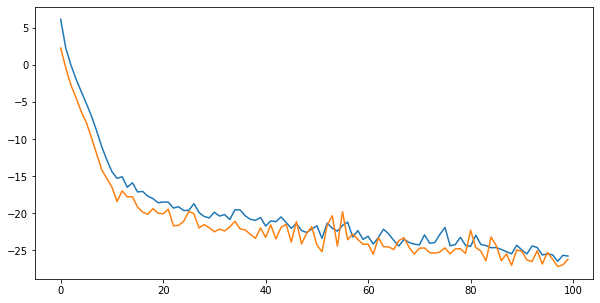

In [8]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# **Model prediction with MDN**

In [9]:
y_test_out = model.predict(x_test)

# y_samples - output from MDN, contains all information
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test_out, OUTPUT_DIMS, N_MIXES, temp=1.0)




In [10]:

# Split up the mixture parameters (for future fun)
# means of Gaussians
mus = y_test_out[:,:N_MIXES*OUTPUT_DIMS]
# sigmas of Gaussians
sigs = y_test_out[:,N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]
#pis = mdn.softmax(y_test_out[:,-N_MIXES:], t=1.0)


Average probability error =  0.10393452


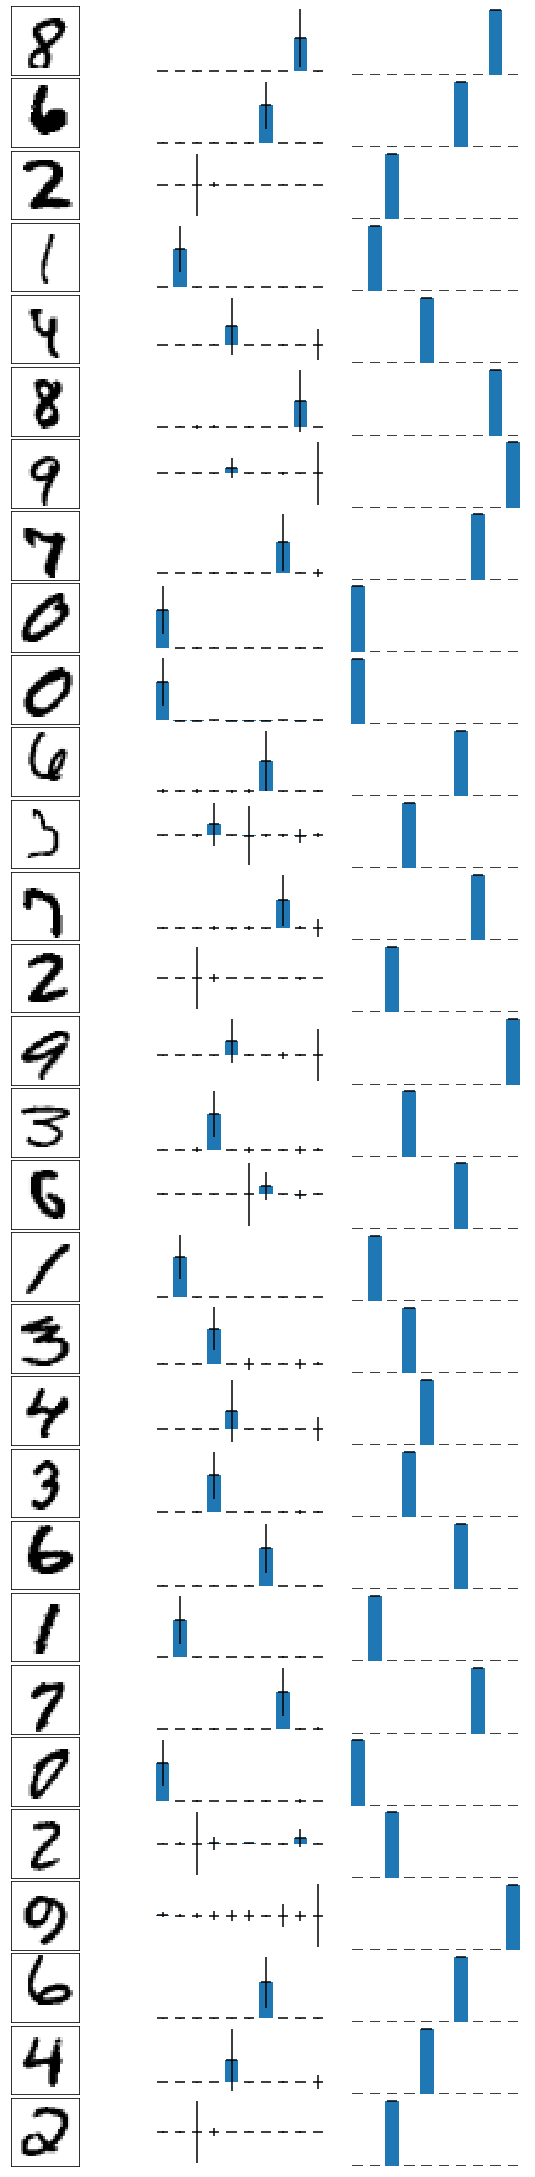

In [11]:
# use the model to predict the labels of the test data



# Plot the prediction
fig = plt.figure(figsize=(8, 30))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
n_img=30
for i in range(n_img):
    ax = fig.add_subplot(n_img, 3, 3*i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')

    ax = fig.add_subplot(n_img, 3, 3*i + 2, xticks=[0,1,2,3,4,5,6,7,8,9], yticks=[])
    xbar = np.linspace(1, OUTPUT_DIMS, num=OUTPUT_DIMS)
    ax.bar(xbar,mus[i],yerr=sigs[i],xerr=0.3,)
    ax.axis('off')

    ax = fig.add_subplot(n_img, 3, 3*i + 3, xticks=[0,1,2,3,4,5,6,7,8,9], yticks=[])
    xbar = np.linspace(1, OUTPUT_DIMS, num=OUTPUT_DIMS)
    ax.bar(xbar,y_test[i],yerr=0.0,xerr=0.3)
    ax.axis('off')



print("Average probability error = ",np.mean(sigs))    